In [ ]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import math

import os
import shutil

import pickle

import pandas as pd
import numpy as np
import tqdm

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn as nn
from pytorch_metric_learning import samplers, miners, losses
import pytorch_lightning as pl
import tensorboard
from IPython.display import display


                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
!nvidia-smi

Wed Apr  7 10:26:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
zip_path = '/content/drive/MyDrive/ParkingLot-20210127T190922Z-001.zip'
polar_path = '/content/datasets/ParkingLot/polar.zip'
polar_out_path = '/content/datasets/ParkingLot/'
out_path = '/content/datasets'

if not os.path.exists(out_path):
  os.mkdir(out_path)

shutil.unpack_archive(zip_path, out_path)
shutil.unpack_archive(polar_path, polar_out_path)

assert os.path.exists('/content/datasets/ParkingLot')

In [7]:
def find_position(image, dataframes: np.array) -> np.array:
    value = np.int(image) / 1e9
    images_timestamps = np.copy(dataframes[:, 0])
    images_timestamps = images_timestamps / 1e9
    time_diff = np.abs(images_timestamps - value)
    if np.amin(time_diff) > 1:
        # print(f"Cannot find matching position for file: {image}")
        return None
    result = np.where(time_diff == np.amin(time_diff))
    result_idx = result[0][0]
    # match = str((dataframes[result_idx, 0] / 1e9)).replace(".","")
    # print(f"Value: {image} is matched with {match} with timediff {np.amin(time_diff)}")
    return np.array([dataframes[result_idx, 1], dataframes[result_idx, 2], dataframes[result_idx, 3]])

def get_images_timestamps(images_path):
    images = os.listdir(images_path)
    for idx, img in enumerate(images):
        images[idx] = np.int(img.split(".")[0])
    return np.array(images)

def dataframes_to_numpy(dataframes) -> np.array:
    retv = []
    for _, row in dataframes.iterrows():
        frame = [row["timestamp"], row["pos_x"], row["pos_y"], row["pos_z"]]
        retv.append(np.array(frame))

    return np.array(retv)

def preprocess_positions(dataframes : np.array, images_path):
    retv = []
    images = get_images_timestamps(images_path)

    for image in images:
        matching_position = find_position(image, dataframes)
        if matching_position is not None:
            retv.append({
                "timestamp": image,
                "position" : matching_position
            })

    return retv

def is_negative(position_1, position_2):
    temp = np.power(position_1 - position_2, 2)
    return math.sqrt(temp[0] + temp[1] + temp[2]) >= 30

def is_positive(position_1, position_2):
    temp = np.power(position_1 - position_2, 2)
    return math.sqrt(temp[0] + temp[1] + temp[2]) <= 10


def create_dataset_from_frames(dataframes):
    dataset = {}

    for idx, elem in enumerate(dataframes):
        positives = [0] * len(dataframes)
        negatives = [0] * len(dataframes)
        position = elem["position"]

        for index, example in enumerate(dataframes):
            if index == idx:
                continue
            exaple_position = example["position"]
            if is_positive(position, exaple_position):
                positives[index] = 1
            elif is_negative(position, exaple_position):
                negatives[index] = 1

        single_frame = {
            "query": elem["timestamp"],
            "positives" : positives,
            "negatives" : negatives
        }

        dataset[idx] = single_frame

    return dataset

def get_test_frames(dataframes):
    train_frames = []
    test_frames = []

    for frame in dataframes:
        if frame["position"][0] < 3.47e5 and frame["position"][1] < 4.04e6:
            test_frames.append(frame)
        else:
            train_frames.append(frame)

    return { "train": train_frames, "test": test_frames}

def preprocess_queries(dataset_path, position_filepath, images_path, test=False):

    assert os.path.exists(position_filepath), f"Cannot access position filepath: {position_filepath}"
    assert os.path.exists(dataset_path), f"Cannot access dataset path: {dataset_path}"
    assert os.path.exists(images_path), f"Cannot access dataset path: {images_path}"

    if test is True:
        queries_filepath = os.path.join(dataset_path, "test_processed_queries.pickle")
    else:
        queries_filepath = os.path.join(dataset_path, "train_processed_queries.pickle")

    dataset = {}

    if os.path.exists(queries_filepath):
        print(f"Loading file {queries_filepath}")
        with open(queries_filepath, "rb") as handle:
            dataset = pickle.load(handle)
        return dataset

    df = pd.read_csv(position_filepath, 
                 names = ["timestamp", "rot_x1", "rot_x2", "rot_x3", "pos_x", "rot_y1", "rot_y2", "rot_y3", "pos_y", "rot_z1", "rot_z2", "rot_z3", "pos_z", ], 
                 header = None,
                 dtype = {"timestamp" : np.float64})
    
    df_array = dataframes_to_numpy(df)
    
    # if test is True:
    #     position_frames = get_test_frames(position_frames)

    position_frames = preprocess_positions(df_array, images_path)

    dataset = create_dataset_from_frames(position_frames)

    with open(queries_filepath, "wb") as handle:
        pickle.dump(dataset, handle)

    return dataset


In [17]:
dataset_path = '/content/datasets/ParkingLot'
position_filepath = '/content/datasets/ParkingLot/global_pose.csv'
queries_filepath = '/content/datasets/ParkingLot/processed_queries.pickle'
images_path = '/content/datasets/ParkingLot/polar'

print("Starting querries preprocessing")
queries = preprocess_queries(dataset_path, position_filepath, images_path)
print("Finished querries preprocessing")

Starting querries preprocessing
Finished querries preprocessing


In [18]:
dataset_root = "/content/datasets/ParkingLot"

datasets = make_datasets(dataset_root)

Loading file /content/datasets/ParkingLot/train_processed_queries.pickle


In [ ]:
batch_size = 8
sampler = BatchSampler(datasets["train"], batch_size)
dataloader = DataLoader(datasets["train"], batch_size, sampler=sampler)
miner = HardTripletMiner(distance=LpDistance(power=2))

In [ ]:
print(len(dataloader))

0


In [ ]:
batch = next(iter(dataloader))

8


In [ ]:
for batch in sampler:
    print(batch)

In [ ]:
net = models.resnet34(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)

In [ ]:
batch = next(iter(dataloader))
x, labels = batch

embeddings = net(x)

In [ ]:
positive_mask, negative_mask = get_masks_for_batch(datasets["train"], labels)

In [ ]:
triplets = miner(embeddings, positive_mask, negative_mask)

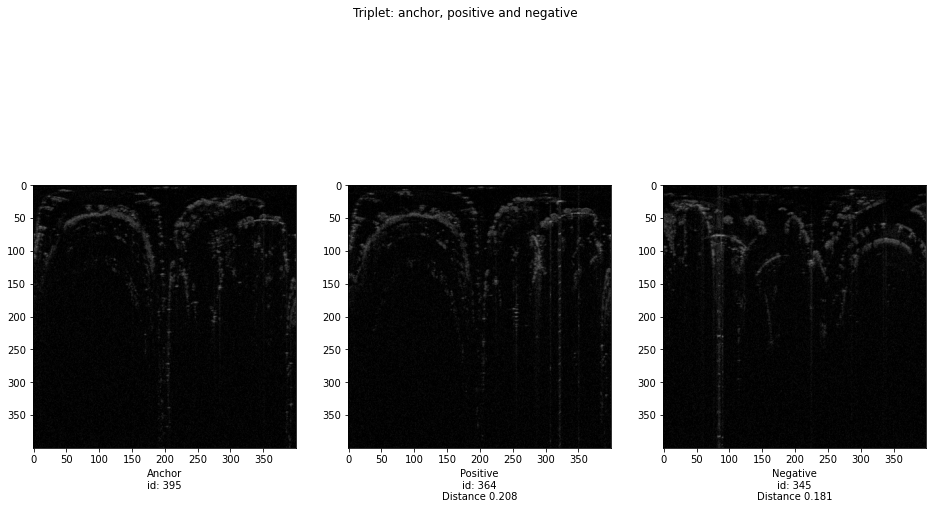

In [ ]:
show_triplet(batch, triplets, 5)

In [8]:
def get_masks_for_batch(dataset, labels):
        positive_mask = []
        negative_mask = []

        for label in labels:
            label_positives = dataset.get_positives(label.item())
            label_negatives = dataset.get_negatives(label.item())
            positives = []
            negatives = []
            for other_label in labels:
                if other_label.item() in label_positives:
                    positives.append(True)
                    negatives.append(False)
                elif other_label.item() in label_negatives:
                    negatives.append(True)
                    positives.append(False)
                else:
                    positives.append(False)
                    negatives.append(False)

            positive_mask.append(positives)
            negative_mask.append(negatives)

        return torch.tensor(positive_mask), torch.tensor(negative_mask)

In [10]:
def make_datasets(dataset_root):
    datasets = {}
    train_transform = transforms.Compose([transforms.ToTensor()])
    # test_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([400,400])])
    train_queries_filepath = os.path.join(dataset_root, "train_processed_queries.pickle")
    # test_queries_filepath = os.path.join(dataset_root, "test_processed_queries.pickle")
    datasets["train"] = MulRanDataset(dataset_root, train_queries_filepath, train_transform)
    # datasets["test"] = MulRanDataset(dataset_root, train_queries_filepath, test_transform)
    return datasets

In [11]:
class MulRanDataset(Dataset):
    def __init__(self, dataset_path, queries_filepath, transform=None):
        self.dataset_path = dataset_path
        self.queries_filepath = queries_filepath
        self.transform = transform
        self.queries = self.load_queries_file(self.queries_filepath)

    def __len__(self):
        return len(self.queries)

    def load_queries_file(self, queries_filepath):
        print(f"Loading file {queries_filepath}")
        assert os.path.exists(self.queries_filepath), f"Cannot access queries file {queries_filepath}"
        queries = {}
        with open(queries_filepath, 'rb') as handle:
            queries = pickle.load(handle)
        
        for idx in queries:
            queries[idx]["positives"] = np.where(np.array(queries[idx]["positives"]) == 1)[0]
            queries[idx]["negatives"] = np.where(np.array(queries[idx]["negatives"]) == 1)[0]    

        return queries

    def __getitem__(self, idx):
        query_filename = self.queries[idx]["query"]
        query_image = self.load_picture(query_filename)
        if self.transform is not None:
            query_image = self.transform(query_image)
        return query_image, idx
    
    def load_picture(self, query_filename):
        file_path = os.path.join(self.dataset_path, "polar", str(query_filename) + ".png")
        picture = Image.open(file_path)
        picture = picture.convert("RGB")
        return picture
    
    def get_positives(self, idx):
        return self.queries[idx]["positives"]

    def get_negatives(self, idx):
        return self.queries[idx]["negatives"]

    def print_info(self):
        print(f"Dataset contains {len(queries)} queries")
    

In [12]:
from torch.utils.data import DataLoader, Sampler
import copy
import random

class BatchSampler(Sampler):
    def __init__(self, dataset: MulRanDataset, batch_size: int, batch_size_limit:int = None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.k = 2 # No of positive examples
        if self.batch_size < 2 * self.k:
            self.batch_size = 2 * self.k
            print(f"Warning: Batch too small. Batch size increased to {self.batch}")
        
        self.batch_idx = []
        self.elems_idx = {}
        for idx in self.dataset.queries:
            self.elems_idx[idx] = True

    def __len__(self):
        return len(self.batch_idx)

    def __iter__(self):
        self.generate_batches()
        for batch in self.batch_idx:
            for element in batch:
                yield element

    def generate_batches(self):
        self.batch_idx = []
        unused_elements_idx = copy.deepcopy(self.elems_idx)
        current_batch = []
        assert self.k == 2, "Sampler can sample only k=2 elements from th same class"

        while True:
            if len(current_batch) >= self.batch_size or len(unused_elements_idx) == 0:
                if len(current_batch) >= 2 * self.k:
                    assert len(current_batch) % self.k == 0, f"Incorrect batch size: {len(current_batch)}"
                    self.batch_idx.append(current_batch)
                    current_batch = []
                if len(unused_elements_idx) == 0:
                    break
        
            selected_element = random.choice(list(unused_elements_idx))
            unused_elements_idx.pop(selected_element)
            positives = self.dataset.get_positives(selected_element)
            if len(positives) == 0:
                # No positives found, try another element
                continue
            
            unused_positives = [e for e in positives if e in unused_elements_idx]

            if len(unused_positives) > 0:
                second_positive = random.choice(unused_positives)
                unused_elements_idx.pop(second_positive)
            else:
                second_positive = random.choice(positives)

            current_batch += [selected_element, second_positive]
            
        for batch in self.batch_idx:
            assert len(batch) % self.k == 0, f"Incorrect batch size: {len(batch)}"


In [13]:
from pytorch_metric_learning.distances import LpDistance

class HardTripletMiner():
    def __init__(self, distance):
        self.distance = distance
        self.max_pos_pair_dist = None
        self.max_neg_pair_dist = None
        self.mean_pos_pair_dist = None
        self.mean_neg_pair_dist = None
        self.min_pos_pair_dist = None
        self.min_neg_pair_dist = None

    def __call__(self, embeddings, positives_mask, negatives_mask):
        assert embeddings.dim() == 2
        d_embeddings = embeddings.detach()
        with torch.no_grad():
            hard_triplets = self.mine(d_embeddings, positives_mask, negatives_mask)
        return hard_triplets

    def mine(self, embeddings, positives_mask, negatives_mask):
        # Based on pytorch-metric-learning implementation
        dist_mat = self.distance(embeddings)
        (hardest_positive_dist, hardest_positive_indices), a1p_keep = get_max_per_row(dist_mat, positives_mask)
        (hardest_negative_dist, hardest_negative_indices), a2n_keep = get_min_per_row(dist_mat, negatives_mask)
        a_keep_idx = torch.where(a1p_keep & a2n_keep)
        a = torch.arange(dist_mat.size(0)).to(hardest_positive_indices.device)[a_keep_idx]
        p = hardest_positive_indices[a_keep_idx]
        n = hardest_negative_indices[a_keep_idx]
        self.max_pos_pair_dist = torch.max(hardest_positive_dist).item()
        self.max_neg_pair_dist = torch.max(hardest_negative_dist).item()
        self.mean_pos_pair_dist = torch.mean(hardest_positive_dist).item()
        self.mean_neg_pair_dist = torch.mean(hardest_negative_dist).item()
        self.min_pos_pair_dist = torch.min(hardest_positive_dist).item()
        self.min_neg_pair_dist = torch.min(hardest_negative_dist).item()
        return a, p, n


def get_max_per_row(mat, mask):
    non_zero_rows = torch.any(mask, dim=1)
    mat_masked = mat.clone()
    mat_masked[~mask] = 0
    return torch.max(mat_masked, dim=1), non_zero_rows


def get_min_per_row(mat, mask):
    non_inf_rows = torch.any(mask, dim=1)
    mat_masked = mat.clone()
    mat_masked[~mask] = float('inf')
    return torch.min(mat_masked, dim=1), non_inf_rows

In [20]:
import pytorch_lightning as pl
from torchvision import models
import torch.nn as nn
from pytorch_metric_learning import losses

class MetricLearner(pl.LightningModule):
    def __init__(self, dataset_root, embeding_size=256, margin=0.4, batchsize=32):
        super().__init__()

        self.save_hyperparameters()
        self.dataset_root = dataset_root
        self.batch_size = batch_size
        self.margin = margin
        self.net = models.resnet34(pretrained=True)
        self.net.fc = nn.Linear(self.net.fc.in_features, embeding_size)

        self.miner = HardTripletMiner(distance=LpDistance(power=2))
        self.loss = losses.TripletMarginLoss(margin=self.margin)

    @pl.core.decorators.auto_move_data
    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        positive_mask, negative_mask = get_masks_for_batch(self.train_dataset, labels)
        triplets = self.miner(embeddings, positive_mask, negative_mask)
        dummy_labels = torch.arange(embeddings.shape[0]).to(embeddings.device)
        loss = self.loss(embeddings, labels, triplets)
        logs = { "train_loss": loss }
        return { "loss" : loss, "log": logs }


    def prepare_data(self):
        train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([400,400])])
        # test_transform = transforms.ToTensor()
        train_queries_filepath = os.path.join(dataset_root, "train_processed_queries.pickle")
        # test_queries_filepath = os.path.join(dataset_root, "test_processed_queries.pickle")
        self.train_dataset = MulRanDataset(dataset_root, train_queries_filepath, train_transform)

        print("train = ", end="")
        self.train_dataset.print_info()

        # self.datasets["test"] = MulRanDataset(dataset_root, test_queries_filepath, test_transform)

        self.train_sampler = BatchSampler(self.train_dataset, self.batch_size)
        # self.samplers["test"] = BatchSampler(self.datasets["test"], self.batch_size)

    def get_masks_for_batch(self, dataset, labels):
        positive_mask = []
        negative_mask = []

        for label in labels:
            label_positives = dataset.get_positives(label.item())
            label_negatives = dataset.get_negatives(label.item())
            positives = []
            negatives = []
            for other_label in labels:
                if other_label.item() in label_positives:
                    positives.append(True)
                    negatives.append(False)
                elif other_label.item() in label_negatives:
                    negatives.append(True)
                    positives.append(False)
                else:
                    positives.append(False)
                    negatives.append(False)

            positive_mask.append(positives)
            negative_mask.append(negatives)

        return torch.tensor(positive_mask), torch.tensor(negative_mask)

    def train_dataloader(self):
        dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=self.train_sampler)
        next(iter(dataloader))
        return dataloader

    def show_dataloader(self):
        self.train_dataset.print_info()
        dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=self.train_sampler)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer


In [31]:
batch_size = 32
embedding_size = 128

tb_logger = pl.loggers.TensorBoardLogger('/content/deep_metric_logs/', name='dm_base')
trainer = pl.Trainer(max_epochs=10, gpus=1, logger=tb_logger ,progress_bar_refresh_rate=10)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


In [25]:
from pytorch_lightning.callbacks import ModelCheckpoint

starting_checkpoint = '/content/checkpoints/starting_checkpoint.ckpt'
trained_checkpoint = '/content/checkpoints/trained_checkpoint.ckpt'

In [32]:
model = MetricLearner(dataset_root, embedding_size, 0.4, batch_size)

In [36]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.core.lightning:
  | Name | Type              | Params
-------------------------------------------
0 | net  | ResNet            | 21.4 M
1 | loss | TripletMarginLoss | 0     
-------------------------------------------
21.4 M    Trainable params
0         Non-trainable params
21.4 M    Total params
85.401    Total estimated model params size (MB)


Loading file /content/datasets/ParkingLot/train_processed_queries.pickle
train = Dataset contains 453 queries


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.
# log on a step or aggregate epoch metric to the logger and/or progress bar (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


1

In [28]:
trainer.save_checkpoint(trained_checkpoint)

In [34]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/deep_metric_logs/dm_base/

In [38]:
dataset = datasets["train"]

embeddings = compute_embeddings(dataset, model)

NameError: ignored

In [ ]:
neighbours_idx = find_nearest_neighbours(embeddings, 5)

(tensor([2, 4, 0, 6, 1, 3, 7]),
 tensor([0.1807, 0.2076, 0.2365, 0.2393, 0.2681, 0.2849, 0.4057],
        grad_fn=<IndexBackward>))

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [16,9]

def display_batch(batch):
    imgs, classes = batch
    n_images_per_row = 8
    n_rows = int(np.ceil(len(imgs) / n_images_per_row))
    fig, axis = plt.subplots(n_rows, n_images_per_row)
    for ndx in range(len(imgs)):
      row = ndx // n_images_per_row
      col = ndx % n_images_per_row
      axis[row, col].imshow(tensor_to_image(imgs[ndx]))
      axis[row, col].set_xlabel(classes[ndx].item())


def tensor_to_image(tensor_image):
    img_size = (400, 400)

    to_pil_image = transforms.Compose([transforms.Resize(img_size), transforms.ToPILImage()])
    image = to_pil_image(tensor_image)
    return image

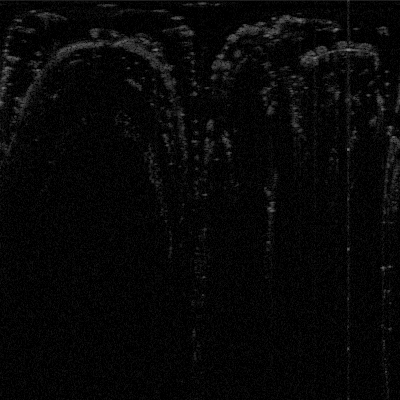

In [ ]:
image = tensor_to_image()

display(image)

In [ ]:
def polar_to_carthesian(polar_image_tensor):
  radius, theta = image_tensor[0].size()
  cart_image_tensor = torch.zeros(torch.Size([3 ,2 * radius + 1, 2 * radius + 1]))
  for i in range(0,3):
    for r in range(0, radius):
      for t in range(0, theta):
        x = radius - r * math.cos(t * 2 * math.pi / theta) + 1
        y = radius + r * math.sin(t * 2 * math.pi / theta) + 1
        cart_image_tensor[i][math.floor(x)][math.floor(y)] = polar_image_tensor[i][r][t]      
  return cart_image_tensor


carthesian_image = polar_to_carthesian(image_tensor)

NameError: ignored

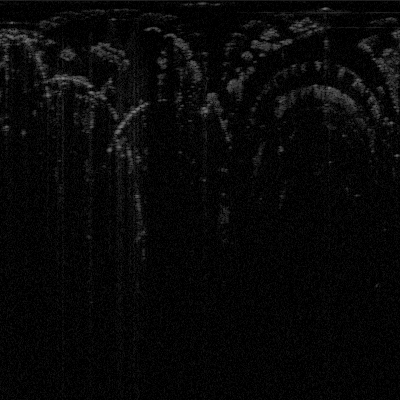

In [ ]:
image_tensor, label = datasets["train"][7]
image = tensor_to_image(image_tensor)

display(image)

In [ ]:
def display_simmilar_images(ds, class_name, max_images=10, n_images_per_row=5):
    class_images_ndx = [ndx for ndx, name in enumerate(ds.class_names) if name==class_name]
    n_images = min(len(class_images_ndx), max_images)
    n_rows = int(np.ceil(n_images / n_images_per_row))
    fig, axis = plt.subplots(n_rows, n_images_per_row)
    fig.suptitle('ID zdjęcia: {}'.format(class_name))
    for ndx, image_ndx in enumerate(class_images_ndx[:n_images]):
      x, _ = ds[image_ndx]
      row = ndx // n_images_per_row
      col = ndx % n_images_per_row
      axis[row, col].imshow(tensor_to_image(x))

In [ ]:
def compute_embeddings(dataset, model):
  model.to(device)
  model.eval()

  embeddings = None
  for ndx, (x, _) in enumerate(dataset):    
    x = x.to(device)
    x = x.unsqueeze(0).contiguous() 
    with torch.no_grad():
      y = model(x).squeeze(0)
    if embeddings is None:
        ds_len = len(dataset)
        embeddings = torch.zeros((ds_len, y.shape[0]), dtype=y.dtype, device=x.device)

    embeddings[ndx] = y

  assert len(embeddings) == len(dataset)

  return embeddings

In [ ]:
def find_nearest_neighbours(embeddings, query_ndx, k=7):
  y = embeddings[query_ndx]
  dist = torch.norm(embeddings - y, p=2, dim=1)
  values, nn_ndx = torch.topk(dist, k + 1, largest=False, sorted=True)
  nn_ndx = nn_ndx[1:]
  return nn_ndx, dist[nn_ndx]

In [ ]:
plt.rcParams["figure.figsize"] = [16,9]

def show_triplet(batch, triplets, i ):
  x, labels = batch
  anchors, positives, negatives = triplets

  fig, axis = plt.subplots(1, 3)
  anchor_ndx = anchors[i]
  positive_ndx = positives[i]
  negative_ndx = negatives[i]

  anchor2pos_dist = torch.norm(x[anchor_ndx] - x[positive_ndx], p=2)
  anchor2neg_dist = torch.norm(x[anchor_ndx] - x[negative_ndx], p=2)
  anchor2pos_dist = torch.norm(embeddings[anchor_ndx] - embeddings[positive_ndx], p=2)
  anchor2neg_dist = torch.norm(embeddings[anchor_ndx] - embeddings[negative_ndx], p=2)

  fig.suptitle('Triplet: anchor, positive and negative')
  axis[0].imshow(tensor_to_image(x[anchor_ndx]))
  axis[0].set_xlabel('Anchor\nid: {}'.format(labels[anchor_ndx].item()))
  axis[1].imshow(tensor_to_image(x[positives[i]]))
  axis[1].set_xlabel('Positive\nid: {}\nDistance {:0.3f}'.format(labels[positive_ndx].item(), anchor2pos_dist))
  axis[2].imshow(tensor_to_image(x[negatives[i]]))
  axis[2].set_xlabel('Negative\nid: {}\nDistance {:0.3f}'.format(labels[negative_ndx].item(), anchor2neg_dist))